In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Configuration pour éviter les erreurs de mémoire GPU (Optionnel mais recommandé en local)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU détecté : {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ Aucun GPU détecté. L'entraînement se fera sur CPU (plus lent).")

# Paramètres globaux
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

2025-12-01 09:01:31.969469: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 09:01:32.280640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 09:01:33.944937: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✅ GPU détecté : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import zipfile

# --- CONFIGURATION ET TÉLÉCHARGEMENT KAGGLE ---

# 1. Vérification de la présence de la clé API
if not os.path.exists('kaggle.json'):
    print("❌ ERREUR : Le fichier 'kaggle.json' est introuvable dans ce dossier.")
    print("Veuillez télécharger votre clé API depuis votre compte Kaggle (Settings > Create New Token) et placez le fichier 'kaggle.json' à côté de ce notebook.")
else:
    print("✅ Fichier kaggle.json trouvé.")
    
    # 2. Configuration de l'environnement pour utiliser le json local
    os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
    
    # Installation de la librairie kaggle si nécessaire
    # !pip install kaggle --upgrade

    # 3. Téléchargement du dataset
    dataset_name = "amerzishminha/forest-fire-smoke-and-non-fire-image-dataset"
    zip_name = "forest-fire-smoke-and-non-fire-image-dataset.zip"
    
    print(f"⬇️ Démarrage du téléchargement de {dataset_name}...")
    # L'option --force écrase le fichier s'il existe déjà pour éviter les erreurs
    !kaggle datasets download -d {dataset_name} --force

    # 4. Extraction
    extract_path = "./dataset_local" # On extrait dans un sous-dossier pour rester propre
    
    if os.path.exists(zip_name):
        print("📦 Extraction de l'archive zip...")
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("✅ Extraction terminée.")
        
        # 5. Détection automatique des chemins Train/Test
        # Ce dataset crée souvent un sous-dossier intermédiaire, on le détecte ici :
        BASE_DIR = extract_path
        
        # On regarde s'il y a un sous-dossier unique (ex: FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET)
        contents = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
        if len(contents) > 0 and "FOREST" in contents[0]:
             BASE_DIR = os.path.join(extract_path, contents[0])
        
        TRAIN_DIR = os.path.join(BASE_DIR, 'train')
        TEST_DIR = os.path.join(BASE_DIR, 'test')

        if os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR):
            print(f"\n✅ Configuration réussie !")
            print(f"📂 Dossier Train : {TRAIN_DIR}")
            print(f"📂 Dossier Test : {TEST_DIR}")
        else:
            print(f"❌ Erreur : Les dossiers 'train' et 'test' sont introuvables dans {BASE_DIR}")
            print(f"Contenu du dossier : {os.listdir(BASE_DIR)}")
            
    else:
        print("❌ Erreur : Le téléchargement a échoué (fichier zip absent).")

✅ Fichier kaggle.json trouvé.
⬇️ Démarrage du téléchargement de amerzishminha/forest-fire-smoke-and-non-fire-image-dataset...
Dataset URL: https://www.kaggle.com/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset
License(s): CC0-1.0
100%|██████████████████████████████████████▉| 6.41G/6.43G [00:31<00:00, 247MB/s]
100%|███████████████████████████████████████| 6.43G/6.43G [00:32<00:00, 215MB/s]
📦 Extraction de l'archive zip...
✅ Extraction terminée.

✅ Configuration réussie !
📂 Dossier Train : ./dataset_local/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train
📂 Dossier Test : ./dataset_local/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Création des générateurs avec le prétraitement spécifique à MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    # Vous pouvez ajouter de l'augmentation ici (rotation, zoom...) si nécessaire
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("--- Chargement des données d'entraînement ---")
# Utilisation de la variable TRAIN_DIR définie dans la cellule précédente
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\n--- Chargement des données de test ---")
# Utilisation de la variable TEST_DIR définie dans la cellule précédente
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nClasses détectées : {train_generator.class_indices}")

2025-12-01 09:08:36.113523: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 09:08:36.182247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 09:08:37.976765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


--- Chargement des données d'entraînement ---
Found 32398 images belonging to 3 classes.

--- Chargement des données de test ---
Found 10500 images belonging to 3 classes.

Classes détectées : {'Smoke': 0, 'fire': 1, 'non fire': 2}


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

def build_model():
    # Chargement du backbone pré-entraîné sur ImageNet (sans la tête)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Construction de la tête personnalisée (Custom Head)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)  # Dropout 30% pour réduire l'overfitting
    x = Dense(128, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes de sortie

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = build_model()
print("✅ Modèle construit avec succès.")

I0000 00:00:1764580134.474720   18843 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Modèle construit avec succès.


In [6]:
from tensorflow.keras.optimizers import Adam

print("\n--- Démarrage Phase 1 : Entraînement de la tête seulement ---")

# 1. On gèle le backbone
for layer in base_model.layers:
    layer.trainable = False

# 2. Compilation
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. Entraînement (2 époques)
history_phase1 = model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator
)


--- Démarrage Phase 1 : Entraînement de la tête seulement ---
Epoch 1/2


2025-12-01 09:09:18.817663: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ca4fc001710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-01 09:09:18.817685: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-01 09:09:18.997151: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-01 09:09:19.966863: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-01 09:09:28.296640: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 09:09:28.438612: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time h

 401/1013 ━━━━━━━━━━━━━━━━━━━━ 2:10 214ms/step - accuracy: 0.8146 - loss: 0.4753

2025-12-01 09:11:05.208627: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 09:11:05.346486: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1013/1013 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8794 - loss: 0.3259

2025-12-01 09:14:55.192435: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 09:14:55.330563: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1013/1013 ━━━━━━━━━━━━━━━━━━━━ 343s 322ms/step - accuracy: 0.9349 - loss: 0.1950 - val_accuracy: 0.9640 - val_loss: 0.1113
Epoch 2/2
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 267s 264ms/step - accuracy: 0.9663 - loss: 0.1039 - val_accuracy: 0.9712 - val_loss: 0.0860


In [7]:
print("\n--- Démarrage Phase 2 : Fine-tuning des 20 dernières couches ---")

# 1. On dégèle les dernières couches
for layer in base_model.layers[-20:]:
    layer.trainable = True

# 2. Re-compilation avec learning rate faible
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. Entraînement (2 époques supplémentaires)
history_phase2 = model.fit(
    train_generator,
    epochs=2, 
    validation_data=validation_generator
)


--- Démarrage Phase 2 : Fine-tuning des 20 dernières couches ---
Epoch 1/2
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 296s 277ms/step - accuracy: 0.9540 - loss: 0.1370 - val_accuracy: 0.9812 - val_loss: 0.0606
Epoch 2/2
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 260s 257ms/step - accuracy: 0.9747 - loss: 0.0807 - val_accuracy: 0.9872 - val_loss: 0.0414


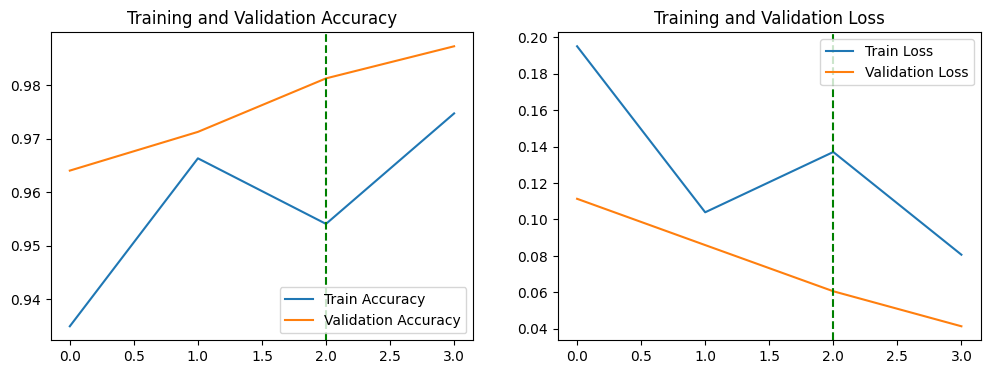

In [8]:
import matplotlib.pyplot as plt

def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.axvline(x=2, color='green', linestyle='--', label='Début Fine Tuning')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.axvline(x=2, color='green', linestyle='--')
    
    plt.show()

plot_history(history_phase1, history_phase2)

⏳ Génération des prédictions (cela peut prendre un moment)...
329/329 ━━━━━━━━━━━━━━━━━━━━ 79s 219ms/step


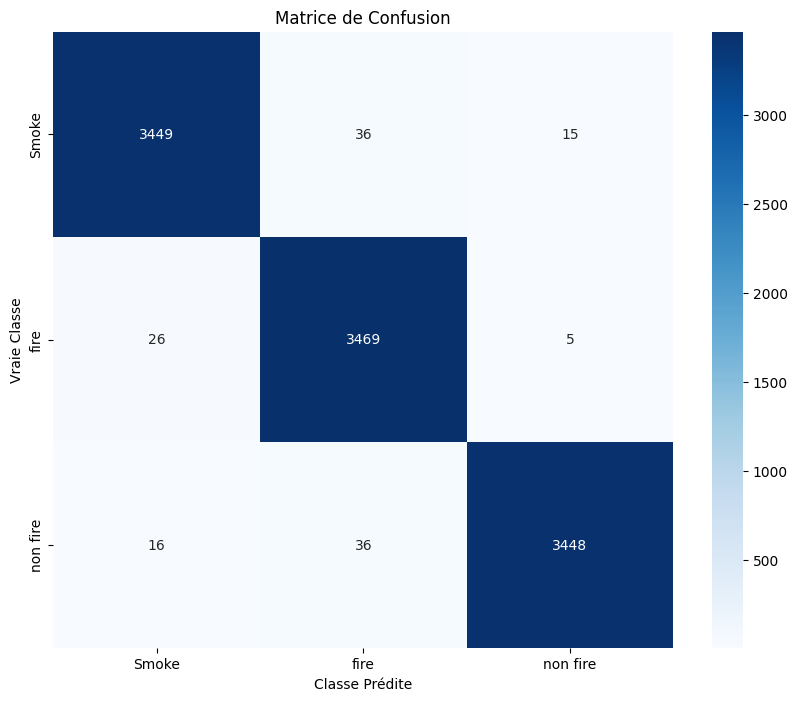


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

       Smoke     0.9880    0.9854    0.9867      3500
        fire     0.9797    0.9911    0.9854      3500
    non fire     0.9942    0.9851    0.9897      3500

    accuracy                         0.9872     10500
   macro avg     0.9873    0.9872    0.9872     10500
weighted avg     0.9873    0.9872    0.9872     10500



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_and_plot_metrics(model, validation_generator):
    # 1. Prédiction sur l'ensemble du dataset de validation
    print("⏳ Génération des prédictions (cela peut prendre un moment)...")
    
    # Important : Reset du générateur pour commencer au début
    validation_generator.reset()
    
    # On s'assure que le générateur n'est PAS mélangé (shuffle=False) 
    # (C'était déjà configuré dans votre cellule précédente, mais c'est critique ici)
    
    predictions = model.predict(validation_generator, verbose=1)
    
    # Conversion des probabilités en index de classe (ex: [0.1, 0.9, 0] -> 1)
    y_pred = np.argmax(predictions, axis=1)
    
    # Récupération des vrais labels
    y_true = validation_generator.classes
    
    # Récupération des noms de classes
    class_names = list(validation_generator.class_indices.keys())
    
    # --- 2. MATRICE DE CONFUSION ---
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.show()
    
    # --- 3. RAPPORT DE CLASSIFICATION (Precision, Recall, F1) ---
    print("\n--- RAPPORT DE CLASSIFICATION ---")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Appel de la fonction
evaluate_and_plot_metrics(model, validation_generator)

In [ ]:
import os
from huggingface_hub import HfApi, login

# --- 1. SAUVEGARDE DU MODÈLE EN FORMAT KERAS (.h5) ---
# On garde le format .h5 qui est très stable pour TensorFlow
model_filename = 'mobilenetv2_fire_detector.h5'
model.save(model_filename)
print(f"✅ Modèle sauvegardé localement : {model_filename}")

# --- 2. CONNEXION À HUGGING FACE ---
# Remplacez par votre token 'WRITE' (ou utilisez login() pour une invite interactive)
HF_TOKEN = "${token}" 

# Nom de votre repo sur Hugging Face (ex: "votre_pseudo/fire-detection-mobilenet")
REPO_ID = "yassir2222/fire-detection-mobilenet"

try:
    print("Connexion à Hugging Face...")
    login(token=HF_TOKEN)
    api = HfApi()

    # Création du repo s'il n'existe pas
    api.create_repo(repo_id=REPO_ID, exist_ok=True)
    print(f"✅ Dépôt {REPO_ID} prêt.")

    # --- 3. UPLOAD DU MODÈLE ---
    print(f"⬆️ Upload de {model_filename} en cours...")
    api.upload_file(
        path_or_fileobj=model_filename,
        path_in_repo=model_filename,
        repo_id=REPO_ID,
        repo_type="model",
        commit_message="Upload trained MobileNetV2 model for Fire Detection"
    )
    print("🚀 Upload terminé avec succès !")
    print(f"Lien : https://huggingface.co/{REPO_ID}")

except Exception as e:
    print(f"❌ Erreur lors de l'upload : {e}")

✅ Modèle sauvegardé localement : mobilenetv2_fire_detector.h5
Connexion à Hugging Face...
✅ Dépôt yassir2222/fire-detection-mobilenet prêt.
⬆️ Upload de mobilenetv2_fire_detector.h5 en cours...


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

🚀 Upload terminé avec succès !
Lien : https://huggingface.co/yassir2222/fire-detection-mobilenet
